In [1]:
# Importing libraries for data preprocessing
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(256,512)):
    tar_list, src_list = list(), list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # split into sketch and real images
        real_img, sketch_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sketch_img)
        tar_list.append(real_img)
    return [asarray(src_list), asarray(tar_list)]
 
# dataset path
path = 'preprocessed_dataset/train_white_sketches/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'whitetrainfacesnp.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

C:\Users\PMLS\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loaded:  (4497, 256, 256, 3) (4497, 256, 256, 3)
Saved dataset:  whitetrainfacesnp.npz


Loaded:  (4497, 256, 256, 3) (4497, 256, 256, 3)


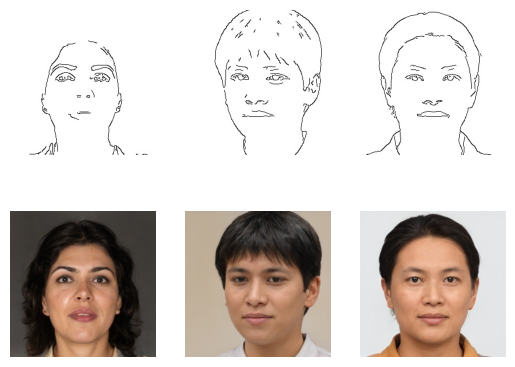

In [1]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('whitetrainfacesnp.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [2]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

C:\Users\PMLS\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)   #The purpose of using an activation function, such as LeakyReLU, after a convolutional layer is to introduce non-linearity into the model.
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)   #This layer normalizes the activations of the previous layer. It can improve the training stability and speed by reducing internal covariate shift.
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [5]:
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [6]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [7]:
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [8]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [9]:
def train(d_model, g_model, gan_model, dataset, n_epochs=1, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    
    #print(bat_per_epo)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated or Fake samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % bat_per_epo == 0:
            summarize_performance(i, g_model, dataset)

In [10]:
# load image data
dataset = load_real_samples('whitetrainfacesnp.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (4497, 256, 256, 3) (4497, 256, 256, 3)


C:\Users\PMLS\anaconda3\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 624ms/step
>1, d1[0.219] d2[2.667] g[53.916]
1/1 [==============================] - 0s 196ms/step
>2, d1[1.097] d2[1.906] g[41.035]
1/1 [==============================] - 0s 147ms/step
>3, d1[1.832] d2[1.209] g[37.980]
1/1 [==============================] - 0s 142ms/step
>4, d1[0.530] d2[0.795] g[31.991]
1/1 [==============================] - 0s 147ms/step
>5, d1[0.489] d2[0.392] g[38.385]
1/1 [==============================] - 0s 185ms/step
>6, d1[0.407] d2[0.410] g[41.963]
1/1 [==============================] - 0s 163ms/step
>7, d1[0.570] d2[0.406] g[37.357]
1/1 [==============================] - 0s 147ms/step
>8, d1[0.334] d2[0.385] g[32.042]
1/1 [==============================] - 0s 147ms/step
>9, d1[0.369] d2[0.328] g[38.467]
1/1 [==============================] - 0s 147ms/step
>10, d1[0.364] d2[0.284] g[22.302]
1/1 [==============================] - 0s 147ms/step
>11, d1[0.359] d2[0.366] g[29.659]
1/1 [==============================] - 0s

1/1 [==============================] - 0s 221ms/step
>186, d1[0.370] d2[0.391] g[26.195]
1/1 [==============================] - 0s 154ms/step
>187, d1[0.186] d2[0.082] g[19.944]
1/1 [==============================] - 0s 147ms/step
>188, d1[0.191] d2[0.058] g[27.499]
1/1 [==============================] - 0s 193ms/step
>189, d1[0.175] d2[0.044] g[53.378]
1/1 [==============================] - 0s 147ms/step
>190, d1[0.354] d2[0.338] g[21.864]
1/1 [==============================] - 0s 161ms/step
>191, d1[0.028] d2[0.138] g[18.864]
1/1 [==============================] - 0s 132ms/step
>192, d1[0.176] d2[0.292] g[42.122]
1/1 [==============================] - 0s 131ms/step
>193, d1[0.294] d2[0.271] g[20.681]
1/1 [==============================] - 0s 147ms/step
>194, d1[0.284] d2[0.450] g[24.982]
1/1 [==============================] - 0s 134ms/step
>195, d1[0.106] d2[0.161] g[30.251]
1/1 [==============================] - 0s 139ms/step
>196, d1[0.171] d2[0.070] g[33.936]
1/1 [================

1/1 [==============================] - 0s 133ms/step
>370, d1[0.005] d2[0.360] g[23.156]
1/1 [==============================] - 0s 142ms/step
>371, d1[0.443] d2[0.172] g[9.540]
1/1 [==============================] - 0s 144ms/step
>372, d1[0.185] d2[0.093] g[15.437]
1/1 [==============================] - 0s 142ms/step
>373, d1[0.011] d2[0.370] g[17.975]
1/1 [==============================] - 0s 129ms/step
>374, d1[0.084] d2[0.036] g[11.413]
1/1 [==============================] - 0s 187ms/step
>375, d1[0.692] d2[0.191] g[37.205]
1/1 [==============================] - 0s 152ms/step
>376, d1[0.030] d2[0.073] g[13.525]
1/1 [==============================] - 0s 141ms/step
>377, d1[0.012] d2[0.025] g[40.183]
1/1 [==============================] - 0s 132ms/step
>378, d1[1.065] d2[1.878] g[16.616]
1/1 [==============================] - 0s 131ms/step
>379, d1[0.073] d2[0.056] g[10.861]
1/1 [==============================] - 0s 180ms/step
>380, d1[0.626] d2[0.101] g[21.891]
1/1 [=================

1/1 [==============================] - 0s 164ms/step
>554, d1[0.008] d2[0.041] g[17.700]
1/1 [==============================] - 0s 178ms/step
>555, d1[0.003] d2[0.008] g[8.494]
1/1 [==============================] - 0s 154ms/step
>556, d1[0.000] d2[0.266] g[33.469]
1/1 [==============================] - 0s 163ms/step
>557, d1[0.016] d2[0.027] g[14.999]
1/1 [==============================] - 0s 142ms/step
>558, d1[0.010] d2[0.012] g[19.233]
1/1 [==============================] - 0s 139ms/step
>559, d1[0.142] d2[0.015] g[18.362]
1/1 [==============================] - 0s 144ms/step
>560, d1[0.015] d2[0.006] g[12.647]
1/1 [==============================] - 0s 185ms/step
>561, d1[0.012] d2[0.007] g[14.315]
1/1 [==============================] - 0s 147ms/step
>562, d1[0.003] d2[0.016] g[13.555]
1/1 [==============================] - 0s 147ms/step
>563, d1[0.005] d2[0.023] g[14.254]
1/1 [==============================] - 0s 188ms/step
>564, d1[0.004] d2[0.002] g[12.654]
1/1 [=================

1/1 [==============================] - 0s 146ms/step
>738, d1[0.034] d2[0.018] g[10.831]
1/1 [==============================] - 0s 178ms/step
>739, d1[0.001] d2[0.071] g[38.210]
1/1 [==============================] - 0s 147ms/step
>740, d1[0.005] d2[0.028] g[21.815]
1/1 [==============================] - 0s 149ms/step
>741, d1[0.017] d2[0.005] g[21.976]
1/1 [==============================] - 0s 155ms/step
>742, d1[0.288] d2[0.112] g[15.554]
1/1 [==============================] - 0s 163ms/step
>743, d1[0.010] d2[0.010] g[17.796]
1/1 [==============================] - 0s 159ms/step
>744, d1[0.391] d2[1.369] g[11.763]
1/1 [==============================] - 0s 161ms/step
>745, d1[0.733] d2[0.023] g[24.032]
1/1 [==============================] - 0s 154ms/step
>746, d1[1.056] d2[0.637] g[9.213]
1/1 [==============================] - 0s 154ms/step
>747, d1[0.042] d2[0.244] g[11.519]
1/1 [==============================] - 0s 163ms/step
>748, d1[0.049] d2[0.044] g[16.261]
1/1 [=================

1/1 [==============================] - 0s 179ms/step
>922, d1[0.003] d2[0.001] g[16.816]
1/1 [==============================] - 0s 177ms/step
>923, d1[0.010] d2[0.001] g[10.194]
1/1 [==============================] - 0s 169ms/step
>924, d1[0.001] d2[0.002] g[15.033]
1/1 [==============================] - 0s 155ms/step
>925, d1[0.001] d2[0.020] g[17.871]
1/1 [==============================] - 0s 155ms/step
>926, d1[0.002] d2[0.002] g[19.166]
1/1 [==============================] - 0s 142ms/step
>927, d1[0.002] d2[0.016] g[9.845]
1/1 [==============================] - 0s 156ms/step
>928, d1[0.000] d2[0.001] g[37.483]
1/1 [==============================] - 0s 201ms/step
>929, d1[0.001] d2[0.004] g[20.840]
1/1 [==============================] - 0s 154ms/step
>930, d1[0.000] d2[0.003] g[8.265]
1/1 [==============================] - 0s 154ms/step
>931, d1[0.000] d2[0.028] g[23.924]
1/1 [==============================] - 0s 155ms/step
>932, d1[0.003] d2[0.027] g[14.610]
1/1 [==================

1/1 [==============================] - 0s 144ms/step
>1014, d1[0.395] d2[0.066] g[14.222]
1/1 [==============================] - 0s 155ms/step
>1015, d1[0.010] d2[0.355] g[22.660]
1/1 [==============================] - 0s 157ms/step
>1016, d1[0.135] d2[0.013] g[32.155]
1/1 [==============================] - 0s 207ms/step
>1017, d1[0.019] d2[0.002] g[16.980]
1/1 [==============================] - 0s 147ms/step
>1018, d1[0.438] d2[0.013] g[8.945]
1/1 [==============================] - 0s 169ms/step
>1019, d1[0.013] d2[0.384] g[10.651]
1/1 [==============================] - 0s 147ms/step
>1020, d1[0.005] d2[0.009] g[13.896]
1/1 [==============================] - 0s 178ms/step
>1021, d1[0.039] d2[0.003] g[22.485]
1/1 [==============================] - 0s 149ms/step
>1022, d1[0.119] d2[0.010] g[16.367]
1/1 [==============================] - 0s 142ms/step
>1023, d1[0.003] d2[0.016] g[39.595]
1/1 [==============================] - 0s 159ms/step
>1024, d1[0.003] d2[0.059] g[12.936]
1/1 [======

1/1 [==============================] - 0s 308ms/step
>1196, d1[0.014] d2[0.747] g[28.380]
1/1 [==============================] - 0s 143ms/step
>1197, d1[1.752] d2[0.291] g[19.689]
1/1 [==============================] - 0s 324ms/step
>1198, d1[0.010] d2[0.358] g[16.621]
1/1 [==============================] - 0s 176ms/step
>1199, d1[0.105] d2[0.004] g[14.300]
1/1 [==============================] - 0s 354ms/step
>1200, d1[0.108] d2[0.334] g[14.620]
1/1 [==============================] - 0s 129ms/step
>1201, d1[0.217] d2[0.004] g[20.799]
1/1 [==============================] - 0s 322ms/step
>1202, d1[0.624] d2[0.644] g[15.820]
1/1 [==============================] - 0s 139ms/step
>1203, d1[0.636] d2[0.279] g[29.685]
1/1 [==============================] - 0s 369ms/step
>1204, d1[0.202] d2[0.023] g[13.248]
1/1 [==============================] - 0s 132ms/step
>1205, d1[0.015] d2[0.869] g[12.753]
1/1 [==============================] - 0s 307ms/step
>1206, d1[0.056] d2[0.011] g[18.936]
1/1 [=====

1/1 [==============================] - 0s 159ms/step
>1378, d1[0.002] d2[0.001] g[19.566]
1/1 [==============================] - 0s 147ms/step
>1379, d1[0.003] d2[0.001] g[16.770]
1/1 [==============================] - 0s 178ms/step
>1380, d1[0.000] d2[0.000] g[10.916]
1/1 [==============================] - 0s 154ms/step
>1381, d1[0.002] d2[0.000] g[27.402]
1/1 [==============================] - 0s 149ms/step
>1382, d1[0.001] d2[0.001] g[11.216]
1/1 [==============================] - 0s 185ms/step
>1383, d1[0.001] d2[0.001] g[10.833]
1/1 [==============================] - 0s 178ms/step
>1384, d1[0.002] d2[0.001] g[12.387]
1/1 [==============================] - 0s 185ms/step
>1385, d1[0.001] d2[0.000] g[8.128]
1/1 [==============================] - 0s 147ms/step
>1386, d1[0.000] d2[0.000] g[10.946]
1/1 [==============================] - 0s 178ms/step
>1387, d1[0.000] d2[0.000] g[9.237]
1/1 [==============================] - 0s 164ms/step
>1388, d1[0.000] d2[0.004] g[11.816]
1/1 [=======

1/1 [==============================] - 0s 163ms/step
>1560, d1[0.000] d2[0.000] g[10.614]
1/1 [==============================] - 0s 170ms/step
>1561, d1[0.000] d2[0.000] g[35.500]
1/1 [==============================] - 0s 195ms/step
>1562, d1[0.000] d2[0.000] g[11.717]
1/1 [==============================] - 0s 164ms/step
>1563, d1[0.000] d2[0.000] g[10.690]
1/1 [==============================] - 0s 155ms/step
>1564, d1[0.002] d2[0.001] g[27.230]
1/1 [==============================] - 0s 185ms/step
>1565, d1[0.000] d2[0.000] g[15.047]
1/1 [==============================] - 0s 169ms/step
>1566, d1[0.000] d2[0.000] g[17.634]
1/1 [==============================] - 0s 155ms/step
>1567, d1[0.001] d2[0.000] g[13.402]
1/1 [==============================] - 0s 154ms/step
>1568, d1[0.001] d2[0.000] g[12.226]
1/1 [==============================] - 0s 163ms/step
>1569, d1[0.001] d2[0.000] g[20.837]
1/1 [==============================] - 0s 163ms/step
>1570, d1[0.001] d2[0.000] g[10.808]
1/1 [=====

1/1 [==============================] - 0s 142ms/step
>1742, d1[0.000] d2[0.001] g[14.872]
1/1 [==============================] - 0s 147ms/step
>1743, d1[0.001] d2[0.004] g[11.919]
1/1 [==============================] - 0s 162ms/step
>1744, d1[0.000] d2[0.001] g[30.147]
1/1 [==============================] - 0s 139ms/step
>1745, d1[0.000] d2[0.001] g[9.762]
1/1 [==============================] - 0s 185ms/step
>1746, d1[0.000] d2[0.001] g[19.395]
1/1 [==============================] - 0s 201ms/step
>1747, d1[0.000] d2[0.001] g[12.079]
1/1 [==============================] - 0s 163ms/step
>1748, d1[0.000] d2[0.001] g[10.673]
1/1 [==============================] - 0s 185ms/step
>1749, d1[0.000] d2[0.000] g[11.189]
1/1 [==============================] - 0s 169ms/step
>1750, d1[0.001] d2[0.001] g[10.290]
1/1 [==============================] - 0s 178ms/step
>1751, d1[0.000] d2[0.008] g[16.496]
1/1 [==============================] - 0s 147ms/step
>1752, d1[0.003] d2[0.001] g[19.944]
1/1 [======

1/1 [==============================] - 0s 171ms/step
>1924, d1[0.002] d2[0.002] g[13.434]
1/1 [==============================] - 0s 167ms/step
>1925, d1[0.001] d2[0.001] g[13.257]
1/1 [==============================] - 0s 169ms/step
>1926, d1[0.001] d2[0.004] g[16.599]
1/1 [==============================] - 0s 147ms/step
>1927, d1[0.000] d2[0.002] g[16.175]
1/1 [==============================] - 0s 159ms/step
>1928, d1[0.000] d2[0.002] g[10.657]
1/1 [==============================] - 0s 163ms/step
>1929, d1[0.001] d2[0.002] g[9.638]
1/1 [==============================] - 0s 149ms/step
>1930, d1[0.003] d2[0.003] g[13.177]
1/1 [==============================] - 0s 202ms/step
>1931, d1[0.001] d2[0.003] g[17.050]
1/1 [==============================] - 0s 144ms/step
>1932, d1[0.001] d2[0.002] g[9.951]
1/1 [==============================] - 0s 147ms/step
>1933, d1[0.002] d2[0.003] g[12.863]
1/1 [==============================] - 0s 178ms/step
>1934, d1[0.001] d2[0.002] g[27.718]
1/1 [=======

1/1 [==============================] - 0s 164ms/step
>2106, d1[0.002] d2[0.001] g[20.837]
1/1 [==============================] - 0s 160ms/step
>2107, d1[0.001] d2[0.001] g[9.647]
1/1 [==============================] - 0s 170ms/step
>2108, d1[0.001] d2[0.003] g[9.892]
1/1 [==============================] - 0s 181ms/step
>2109, d1[0.001] d2[0.001] g[18.358]
1/1 [==============================] - 0s 147ms/step
>2110, d1[0.001] d2[0.001] g[8.579]
1/1 [==============================] - 0s 191ms/step
>2111, d1[0.001] d2[0.001] g[8.313]
1/1 [==============================] - 0s 176ms/step
>2112, d1[0.001] d2[0.000] g[17.396]
1/1 [==============================] - 0s 169ms/step
>2113, d1[0.001] d2[0.000] g[26.156]
1/1 [==============================] - 0s 206ms/step
>2114, d1[0.001] d2[0.001] g[15.360]
1/1 [==============================] - 0s 219ms/step
>2115, d1[0.001] d2[0.001] g[30.034]
1/1 [==============================] - 0s 185ms/step
>2116, d1[0.002] d2[0.000] g[10.913]
1/1 [=========

1/1 [==============================] - 0s 178ms/step
>2288, d1[0.000] d2[0.000] g[14.061]
1/1 [==============================] - 0s 170ms/step
>2289, d1[0.001] d2[0.000] g[14.341]
1/1 [==============================] - 0s 178ms/step
>2290, d1[0.000] d2[0.000] g[12.647]
1/1 [==============================] - 0s 154ms/step
>2291, d1[0.000] d2[0.000] g[11.561]
1/1 [==============================] - 0s 171ms/step
>2292, d1[0.000] d2[0.000] g[25.060]
1/1 [==============================] - 0s 169ms/step
>2293, d1[0.000] d2[0.000] g[22.105]
1/1 [==============================] - 0s 185ms/step
>2294, d1[0.000] d2[0.000] g[12.639]
1/1 [==============================] - 0s 169ms/step
>2295, d1[0.000] d2[0.000] g[13.104]
1/1 [==============================] - 0s 169ms/step
>2296, d1[0.000] d2[0.000] g[11.426]
1/1 [==============================] - 0s 190ms/step
>2297, d1[0.000] d2[0.000] g[16.587]
1/1 [==============================] - 0s 173ms/step
>2298, d1[0.000] d2[0.000] g[13.329]
1/1 [=====

1/1 [==============================] - 0s 184ms/step
>2470, d1[0.008] d2[0.001] g[20.206]
1/1 [==============================] - 0s 178ms/step
>2471, d1[0.020] d2[0.001] g[26.974]
1/1 [==============================] - 0s 207ms/step
>2472, d1[0.001] d2[0.000] g[18.284]
1/1 [==============================] - 0s 168ms/step
>2473, d1[0.002] d2[0.001] g[16.167]
1/1 [==============================] - 0s 174ms/step
>2474, d1[0.001] d2[0.001] g[13.275]
1/1 [==============================] - 0s 164ms/step
>2475, d1[0.003] d2[0.000] g[23.334]
1/1 [==============================] - 0s 169ms/step
>2476, d1[0.008] d2[0.000] g[12.866]
1/1 [==============================] - 0s 169ms/step
>2477, d1[0.005] d2[0.000] g[9.257]
1/1 [==============================] - 0s 190ms/step
>2478, d1[0.001] d2[0.001] g[13.182]
1/1 [==============================] - 0s 189ms/step
>2479, d1[0.005] d2[0.001] g[16.975]
1/1 [==============================] - 0s 190ms/step
>2480, d1[0.004] d2[0.098] g[10.260]
1/1 [======

1/1 [==============================] - 0s 178ms/step
>2652, d1[0.000] d2[0.000] g[22.779]
1/1 [==============================] - 0s 185ms/step
>2653, d1[0.000] d2[0.001] g[21.432]
1/1 [==============================] - 0s 181ms/step
>2654, d1[0.001] d2[0.000] g[42.274]
1/1 [==============================] - 0s 168ms/step
>2655, d1[0.000] d2[0.000] g[16.938]
1/1 [==============================] - 0s 185ms/step
>2656, d1[0.000] d2[0.001] g[16.809]
1/1 [==============================] - 0s 186ms/step
>2657, d1[0.000] d2[0.001] g[10.706]
1/1 [==============================] - 0s 180ms/step
>2658, d1[0.000] d2[0.001] g[12.977]
1/1 [==============================] - 0s 190ms/step
>2659, d1[0.001] d2[0.002] g[9.464]
1/1 [==============================] - 0s 185ms/step
>2660, d1[0.000] d2[0.001] g[12.577]
1/1 [==============================] - 0s 186ms/step
>2661, d1[0.000] d2[0.000] g[10.676]
1/1 [==============================] - 0s 192ms/step
>2662, d1[0.000] d2[0.000] g[10.461]
1/1 [======

1/1 [==============================] - 0s 219ms/step
>2834, d1[0.000] d2[0.000] g[16.503]
1/1 [==============================] - 0s 200ms/step
>2835, d1[0.000] d2[0.000] g[14.324]
1/1 [==============================] - 0s 227ms/step
>2836, d1[0.000] d2[0.000] g[12.368]
1/1 [==============================] - 0s 200ms/step
>2837, d1[0.000] d2[0.000] g[18.895]
1/1 [==============================] - 0s 210ms/step
>2838, d1[0.000] d2[0.000] g[13.550]
1/1 [==============================] - 0s 189ms/step
>2839, d1[0.000] d2[0.000] g[13.103]
1/1 [==============================] - 0s 184ms/step
>2840, d1[0.000] d2[0.001] g[9.944]
1/1 [==============================] - 0s 194ms/step
>2841, d1[0.000] d2[0.000] g[11.607]
1/1 [==============================] - 0s 180ms/step
>2842, d1[0.000] d2[0.000] g[11.012]
1/1 [==============================] - 0s 247ms/step
>2843, d1[0.000] d2[0.000] g[10.264]
1/1 [==============================] - 0s 176ms/step
>2844, d1[0.000] d2[0.001] g[15.438]
1/1 [======

1/1 [==============================] - 0s 189ms/step
>3016, d1[0.001] d2[0.000] g[14.678]
1/1 [==============================] - 0s 194ms/step
>3017, d1[0.000] d2[0.000] g[44.095]
1/1 [==============================] - 0s 198ms/step
>3018, d1[0.000] d2[0.000] g[58.170]
1/1 [==============================] - 0s 181ms/step
>3019, d1[0.000] d2[0.000] g[7.023]
1/1 [==============================] - 0s 180ms/step
>3020, d1[0.000] d2[0.000] g[19.144]
1/1 [==============================] - 0s 183ms/step
>3021, d1[0.001] d2[0.000] g[9.305]
1/1 [==============================] - 0s 187ms/step
>3022, d1[0.001] d2[0.000] g[15.573]
1/1 [==============================] - 0s 190ms/step
>3023, d1[0.001] d2[0.000] g[19.644]
1/1 [==============================] - 0s 190ms/step
>3024, d1[0.000] d2[0.000] g[10.684]
1/1 [==============================] - 0s 191ms/step
>3025, d1[0.000] d2[0.000] g[9.131]
1/1 [==============================] - 0s 214ms/step
>3026, d1[0.000] d2[0.000] g[9.002]
1/1 [=========

1/1 [==============================] - 0s 185ms/step
>3198, d1[0.001] d2[0.006] g[16.345]
1/1 [==============================] - 0s 196ms/step
>3199, d1[0.004] d2[0.002] g[11.648]
1/1 [==============================] - 0s 204ms/step
>3200, d1[0.017] d2[0.135] g[26.044]
1/1 [==============================] - 0s 210ms/step
>3201, d1[0.001] d2[0.001] g[8.796]
1/1 [==============================] - 0s 201ms/step
>3202, d1[0.005] d2[0.002] g[10.355]
1/1 [==============================] - 0s 201ms/step
>3203, d1[0.021] d2[0.002] g[9.867]
1/1 [==============================] - 0s 185ms/step
>3204, d1[0.011] d2[0.004] g[16.500]
1/1 [==============================] - 0s 186ms/step
>3205, d1[0.009] d2[0.002] g[8.277]
1/1 [==============================] - 0s 185ms/step
>3206, d1[0.002] d2[0.003] g[20.207]
1/1 [==============================] - 0s 201ms/step
>3207, d1[0.004] d2[0.007] g[11.016]
1/1 [==============================] - 0s 191ms/step
>3208, d1[0.003] d2[0.034] g[8.332]
1/1 [=========

1/1 [==============================] - 0s 194ms/step
>3380, d1[0.000] d2[0.001] g[24.652]
1/1 [==============================] - 0s 196ms/step
>3381, d1[0.002] d2[0.001] g[29.678]
1/1 [==============================] - 0s 212ms/step
>3382, d1[0.004] d2[0.003] g[12.637]
1/1 [==============================] - 0s 190ms/step
>3383, d1[0.000] d2[0.007] g[17.725]
1/1 [==============================] - 0s 218ms/step
>3384, d1[0.001] d2[0.003] g[12.258]
1/1 [==============================] - 0s 182ms/step
>3385, d1[0.001] d2[0.006] g[32.971]
1/1 [==============================] - 0s 242ms/step
>3386, d1[0.002] d2[0.004] g[15.184]
1/1 [==============================] - 0s 215ms/step
>3387, d1[0.001] d2[0.002] g[8.431]
1/1 [==============================] - 0s 195ms/step
>3388, d1[0.001] d2[0.008] g[15.299]
1/1 [==============================] - 0s 193ms/step
>3389, d1[0.011] d2[0.002] g[14.521]
1/1 [==============================] - 0s 218ms/step
>3390, d1[0.001] d2[0.002] g[12.048]
1/1 [======

1/1 [==============================] - 0s 216ms/step
>3562, d1[0.009] d2[0.251] g[13.487]
1/1 [==============================] - 0s 216ms/step
>3563, d1[0.084] d2[0.061] g[18.164]
1/1 [==============================] - 0s 217ms/step
>3564, d1[0.466] d2[4.855] g[23.344]
1/1 [==============================] - 0s 200ms/step
>3565, d1[1.322] d2[0.007] g[14.951]
1/1 [==============================] - 0s 220ms/step
>3566, d1[1.039] d2[1.530] g[29.626]
1/1 [==============================] - 0s 209ms/step
>3567, d1[0.027] d2[0.013] g[21.239]
1/1 [==============================] - 0s 207ms/step
>3568, d1[0.528] d2[0.519] g[17.212]
1/1 [==============================] - 0s 212ms/step
>3569, d1[0.204] d2[0.052] g[13.311]
1/1 [==============================] - 0s 201ms/step
>3570, d1[0.044] d2[0.000] g[35.396]
1/1 [==============================] - 0s 216ms/step
>3571, d1[0.104] d2[0.028] g[14.372]
1/1 [==============================] - 0s 201ms/step
>3572, d1[0.102] d2[0.009] g[29.569]
1/1 [=====

1/1 [==============================] - 0s 178ms/step
>3744, d1[0.002] d2[0.001] g[9.442]
1/1 [==============================] - 0s 190ms/step
>3745, d1[0.004] d2[0.003] g[13.990]
1/1 [==============================] - 0s 185ms/step
>3746, d1[0.023] d2[0.295] g[11.745]
1/1 [==============================] - 0s 185ms/step
>3747, d1[0.120] d2[0.000] g[11.320]
1/1 [==============================] - 0s 200ms/step
>3748, d1[0.026] d2[0.000] g[24.803]
1/1 [==============================] - 0s 209ms/step
>3749, d1[0.020] d2[0.002] g[12.891]
1/1 [==============================] - 0s 203ms/step
>3750, d1[0.002] d2[0.002] g[19.756]
1/1 [==============================] - 0s 197ms/step
>3751, d1[0.012] d2[0.000] g[12.343]
1/1 [==============================] - 0s 186ms/step
>3752, d1[0.002] d2[0.003] g[22.427]
1/1 [==============================] - 0s 191ms/step
>3753, d1[0.004] d2[0.001] g[14.180]
1/1 [==============================] - 0s 189ms/step
>3754, d1[0.004] d2[0.002] g[9.117]
1/1 [=======

1/1 [==============================] - 0s 200ms/step
>3926, d1[0.001] d2[0.001] g[13.259]
1/1 [==============================] - 0s 223ms/step
>3927, d1[0.005] d2[0.003] g[8.517]
1/1 [==============================] - 0s 201ms/step
>3928, d1[0.001] d2[0.003] g[11.466]
1/1 [==============================] - 0s 178ms/step
>3929, d1[0.001] d2[0.001] g[25.534]
1/1 [==============================] - 0s 186ms/step
>3930, d1[0.000] d2[0.001] g[13.925]
1/1 [==============================] - 0s 186ms/step
>3931, d1[0.000] d2[0.001] g[8.775]
1/1 [==============================] - 0s 190ms/step
>3932, d1[0.001] d2[0.001] g[17.163]
1/1 [==============================] - 0s 185ms/step
>3933, d1[0.001] d2[0.001] g[14.401]
1/1 [==============================] - 0s 193ms/step
>3934, d1[0.001] d2[0.001] g[7.154]
1/1 [==============================] - 0s 188ms/step
>3935, d1[0.001] d2[0.000] g[10.511]
1/1 [==============================] - 0s 195ms/step
>3936, d1[0.000] d2[0.000] g[17.132]
1/1 [========

1/1 [==============================] - 0s 214ms/step
>4108, d1[0.356] d2[0.036] g[9.091]
1/1 [==============================] - 0s 190ms/step
>4109, d1[0.033] d2[0.773] g[22.365]
1/1 [==============================] - 0s 185ms/step
>4110, d1[0.051] d2[0.501] g[16.488]
1/1 [==============================] - 0s 200ms/step
>4111, d1[0.051] d2[0.005] g[13.193]
1/1 [==============================] - 0s 194ms/step
>4112, d1[0.022] d2[0.009] g[56.134]
1/1 [==============================] - 0s 186ms/step
>4113, d1[2.199] d2[0.006] g[14.081]
1/1 [==============================] - 0s 203ms/step
>4114, d1[0.032] d2[0.693] g[11.078]
1/1 [==============================] - 0s 366ms/step
>4115, d1[0.061] d2[0.018] g[11.752]
1/1 [==============================] - 0s 197ms/step
>4116, d1[0.170] d2[0.045] g[9.758]
1/1 [==============================] - 0s 185ms/step
>4117, d1[0.059] d2[0.061] g[13.403]
1/1 [==============================] - 0s 187ms/step
>4118, d1[0.014] d2[0.005] g[25.975]
1/1 [=======

1/1 [==============================] - 0s 187ms/step
>4290, d1[0.000] d2[0.164] g[28.466]
1/1 [==============================] - 0s 185ms/step
>4291, d1[0.001] d2[0.000] g[8.455]
1/1 [==============================] - 0s 188ms/step
>4292, d1[0.002] d2[0.000] g[9.615]
1/1 [==============================] - 0s 191ms/step
>4293, d1[0.009] d2[0.001] g[12.000]
1/1 [==============================] - 0s 203ms/step
>4294, d1[0.003] d2[0.001] g[12.258]
1/1 [==============================] - 0s 201ms/step
>4295, d1[0.002] d2[0.004] g[14.860]
1/1 [==============================] - 0s 217ms/step
>4296, d1[0.004] d2[0.001] g[12.319]
1/1 [==============================] - 0s 201ms/step
>4297, d1[0.034] d2[0.001] g[24.745]
1/1 [==============================] - 0s 185ms/step
>4298, d1[0.415] d2[0.067] g[18.432]
1/1 [==============================] - 0s 185ms/step
>4299, d1[0.001] d2[0.002] g[13.689]
1/1 [==============================] - 0s 206ms/step
>4300, d1[0.012] d2[0.072] g[13.105]
1/1 [=======

1/1 [==============================] - 0s 201ms/step
>4472, d1[0.011] d2[0.000] g[13.870]
1/1 [==============================] - 0s 185ms/step
>4473, d1[0.002] d2[0.003] g[16.871]
1/1 [==============================] - 0s 169ms/step
>4474, d1[0.012] d2[0.001] g[10.080]
1/1 [==============================] - 0s 176ms/step
>4475, d1[0.005] d2[0.027] g[8.315]
1/1 [==============================] - 0s 185ms/step
>4476, d1[0.043] d2[0.001] g[11.465]
1/1 [==============================] - 0s 185ms/step
>4477, d1[0.090] d2[0.024] g[12.203]
1/1 [==============================] - 0s 185ms/step
>4478, d1[0.001] d2[0.009] g[10.131]
1/1 [==============================] - 0s 201ms/step
>4479, d1[0.005] d2[0.013] g[7.692]
1/1 [==============================] - 0s 185ms/step
>4480, d1[0.001] d2[0.001] g[25.807]
1/1 [==============================] - 0s 200ms/step
>4481, d1[0.000] d2[0.002] g[19.727]
1/1 [==============================] - 0s 185ms/step
>4482, d1[0.017] d2[0.001] g[11.606]
1/1 [=======

C:\Users\PMLS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: plot_004497.png and model_004497.h5


In [1]:
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
 
# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

[X1, X2] = load_real_samples('whitetrainfacesnp.npz')
print('Loaded', X1.shape, X2.shape)
model = load_model('model_004497.h5')

C:\Users\PMLS\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loaded (4497, 256, 256, 3) (4497, 256, 256, 3)


1/1 [==============================] - 0s 126ms/step


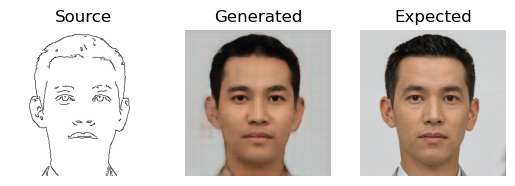

In [7]:
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        pyplot.subplot(1, 3, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(images[i])
        # show title
        pyplot.title(titles[i])
    pyplot.show()
    
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input Image (1, 256, 256, 3)


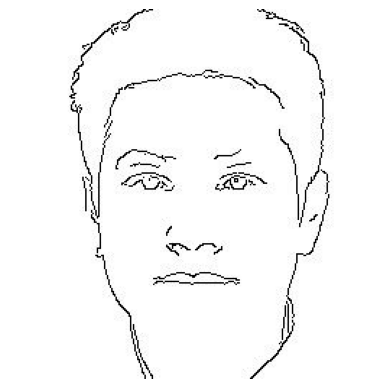

1/1 [==============================] - 0s 335ms/step
Generated Ouput (256, 256, 3)


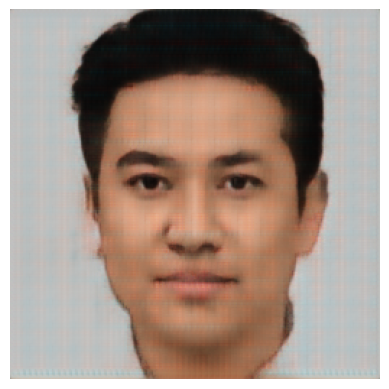

In [11]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import load
from numpy import expand_dims
from matplotlib import pyplot
import tensorflow as tf

def load_image(filename, size=(256,256)):
    # load image with the preferred size
    pixels = load_img(filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # scale from [0,255] to [-1,1]
    pixels = (pixels - 127.5) / 127.5
    # reshape to 1 sample
    pixels = expand_dims(pixels, 0)
    return pixels


src_image = load_image('whitetest.jpg')

src_image1 = tf.reshape(src_image, [256, 256, 3])
# scale from [-1,1] to [0,1]
scr_image1 = (src_image + 1) / 2.0
print('Input Image', src_image.shape)
# plot the image
pyplot.imshow(src_image1)
pyplot.axis('off')
pyplot.show()

# load model
model = load_model('model_004497.h5')

# generate image from source
gen_image = model.predict(src_image)

gen_image = tf.reshape(gen_image, [256, 256, 3])
# scale from [-1,1] to [0,1]
gen_image = (gen_image + 1) / 2.0
print('Generated Ouput', gen_image.shape)
# plot the image
pyplot.imshow(gen_image)
pyplot.axis('off')
pyplot.show()